## Imporst's

In [1]:
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

import shap
import time
import optuna
from scipy.stats import uniform

## 1. Answer the questions from the introduction

### What is leave-one-out? Provide limitations and strengths.

Leave-One-Out (LOOCV) — это частный случай K-Fold-валидации, где
k = n, то есть в каждом разбиении модель обучается на n-1 объектах и тестируется на 1.

Плюсы:
- Использует почти все данные для обучения → минимальное смещение.
- Устойчив к случайности в разбиении.

Минусы:
- Очень дорог по вычислениям при большом n.
- Высокая дисперсия метрики (результаты сильно зависят от каждого объекта).
- Не подходит для больших датасетов и time series.

### How do Grid Search, Randomized Grid Search, and Bayesian optimization work?

| Метод                                        | Как работает                                                                                                                        | Преимущества                                            | Недостатки                                  |
| -------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------- | ------------------------------------------- |
| **Grid Search**                              | Перебирает все комбинации гиперпараметров на заданной сетке.                                                                        | Полный поиск, гарантирует нахождение оптимума на сетке. | Медленный, особенно при >2 параметрах.      |
| **Randomized Search**                        | Случайно выбирает комбинации параметров из заданных распределений.                                                                  | Быстрее, часто находит хорошие решения.                 | Не гарантирует глобальный оптимум.          |
| **Bayesian Optimization (например, Optuna)** | Строит вероятностную модель зависимости метрики от параметров (обычно GP), выбирает новые точки с учётом баланса «explore/exploit». | Быстро сходится к оптимуму, меньше итераций.            | Более сложен, требует настройки и контроля. |



### Explain classification of feature selection methods.

| Тип          | Описание                                                 | Примеры                      |
| ------------ | -------------------------------------------------------- | ---------------------------- |
| **Filter**   | Использует статистические тесты, не зависящие от модели. | Pearson, Chi², Mutual Info   |
| **Wrapper**  | Оценивает признаки, обучая модель (поиск подмножеств).   | RFE, Sequential Selection    |
| **Embedded** | Встроен в процесс обучения модели.                       | Lasso, Tree-based importance |


 ### Explain how Pearson and Chi2 work. 

Коэффициент корреляции Пирсона (Pearson r)

Измеряет линейную зависимость между признаком X и целевой переменной y.

r= cov(X,y) / (σX*σy)

**подходит только для числовых признаков с нормальным распределением.**

Критерий χ² (Chi-Squared)

Используется для категориальных признаков и дискретных данных.

Измеряет, насколько распределение наблюдений отличается от ожидаемого при независимости.

χ^2=∑(O−E)^2 / E

**Высокое значение -> зависимость между переменными.**

 ### Explain how Lasso works. 
 
L1-регуляризация (Lasso) добавляет штраф:

L=||y−Xw||^2 + λ∑|wi|

**часть коэффициентов обнуляется.**

Преимущества:
- Автоматический отбор признаков.
- Регуляризация уменьшает переобучение.
Недостатки:
- Плохо работает при сильно коррелированных признаках (оставит один из пары).


 ### Explain what permutation significance is. 

Permutation Importance измеряет снижение качества модели при случайной перестановке значений отдельного признака.
Если метрика сильно падает -> признак важен.
Преимущества:
- Универсальный, работает с любой моделью.
- Простая интерпретация.
Недостатки:
- Дорог по времени (нужно многократное переобучение или оценка).

 ### Become familiar with SHAP.

Метод интерпретации моделей, основанный на теории игр.

SHAP-значение каждого признака — вклад признака в предсказание модели.

Особенности:
- Универсальный (поддерживает tree, linear, DL-модели).
- Сохраняет свойства аддитивности и локальной точности.
- Позволяет визуализировать влияние признаков (summary plots, force plots).


## 2. Introduction — do all the preprocessing from the previous lesson

Read all the data.

Preprocess the "Interest Level" feature.

Create features:  'Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'.

In [2]:
df = pd.read_json('./data/train.json')
df_test = pd.read_json('./data/test.json')

In [3]:
df["interest_level"] = (
    df["interest_level"]
    .replace({"medium": 1, "low": 0, "high": 2})
    .astype(int)
)

/var/folders/5x/r11gzlss06g7534727qbgv8c0000gn/T/ipykernel_50020/1604800249.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"medium": 1, "low": 0, "high": 2})


In [4]:
df["features"] = (
    df["features"]
    .astype(str)
    .str.replace(r"[\[\]']", "", regex=True)
    .str.replace(r" ", "", regex=True)
    .str.split(",")
    .apply(lambda feats: [f for f in feats if f.strip() != ""])
)

In [5]:
all_feats_df = []
for _, row in df.iterrows():
    all_feats_df.extend(row["features"])

unique_feats_df = set(all_feats_df)

In [6]:
top20 = [f for f,_ in Counter(all_feats_df).most_common(20)]
top20

['Elevator',
 'CatsAllowed',
 'HardwoodFloors',
 'DogsAllowed',
 'Doorman',
 'Dishwasher',
 'NoFee',
 'LaundryinBuilding',
 'FitnessCenter',
 'Pre-War',
 'LaundryinUnit',
 'RoofDeck',
 'OutdoorSpace',
 'DiningRoom',
 'HighSpeedInternet',
 'Balcony',
 'SwimmingPool',
 'LaundryInBuilding',
 'NewConstruction',
 'Terrace']

In [7]:
for f in top20:
    df[f] = df["features"].apply(lambda x: 1 if f in x else 0)
    df_test[f] = df_test["features"].apply(lambda x: 1 if f in x else 0)

In [8]:
feature_list = top20 + ["bathrooms", "bedrooms"]
print(feature_list)

print(len(feature_list))

['Elevator', 'CatsAllowed', 'HardwoodFloors', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace', 'bathrooms', 'bedrooms']
22


In [9]:
X_train = df[feature_list].values
y_train = df["price"].values

X_test = df_test[feature_list].values
y_test = df_test["price"].values

## 3. Implement the next methods:

Split data into 2 parts randomly with parameter test_size (ratio from 0 to 1), return training and test samples.
Randomly split data into 3 parts with parameters validation_size and test_size, return train, validation and test samples.
Split data into 2 parts with parameter date_split, return train and test samples split by date_split param.
Split data into 3 parts with parameters validation_date and test_date, return train, validation and test samples split by input params.
Make split procedure determenistic. What does it mean?

In [10]:
def split_train_test(df, test_size=0.2, random_state=21):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df, test_df

In [11]:
def split_train_val_test(df, validation_size=0.2, test_size=0.2, random_state=21):
    train_df, temp_df = train_test_split(df, test_size=(validation_size + test_size), random_state=random_state)
    rel_val_size = validation_size / (validation_size + test_size)
    val_df, test_df = train_test_split(temp_df, test_size=(1 - rel_val_size), random_state=random_state)
    return train_df, val_df, test_df

In [12]:
def split_by_date(df, date_field, date_split):
    train_df = df[df[date_field] < date_split]
    test_df = df[df[date_field] >= date_split]
    return train_df, test_df

In [13]:
def split_by_date_3(df, date_field, val_date, test_date):
    train_df = df[df[date_field] < val_date]
    val_df = df[(df[date_field] >= val_date) & (df[date_field] < test_date)]
    test_df = df[df[date_field] >= test_date]
    return train_df, val_df, test_df

In [14]:
train_df, test_df = split_train_test(df, test_size=0.2)
display(train_df.head(), test_df.head())

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
35349,2.5,4,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,2016-06-21 04:25:34,WHAT A DEAL - EXTRA LUXURIOUS BUILDING WITH MA...,E 56th St.,"[DiningRoom, Doorman, Elevator, FitnessCenter,...",40.7579,7190402,-73.9653,...,0,0,0,1,0,0,0,0,0,0
31794,1.0,1,61069a7cb537d02dd8ca82a6ccff819c,2016-06-10 02:30:57,The story luxury rental apartment building is...,Sixth Avenue,"[Doorman, Elevator, Terrace, OutdoorSpace, Dog...",40.7452,7134371,-73.9916,...,0,0,1,0,0,0,0,0,0,1
68985,1.0,0,f9bcf216879bdb960304b27d1a286e38,2016-05-11 05:13:11,"The Williamsburg is an extraordinary, Silver L...",373 Wythe Avenue,"[RoofDeck, Elevator, FitnessCenter, Garden/Pat...",40.7121,6995897,-73.9660,...,0,1,1,0,1,0,0,0,0,1
19398,1.0,1,6289dd7229f0d3b87254860764be70ab,2016-06-29 02:13:46,"Thoughtfully designed studio, one- and two-bed...",West 28th Street,"[Doorman, Elevator, DogsAllowed, CatsAllowed]",40.7512,7228717,-74.0026,...,0,0,0,0,0,0,0,0,0,0
20017,1.0,1,5db4639fb15d93c42c78bbd812eb011f,2016-06-03 02:51:03,Amazing bedroom available in Greenwich Village...,Sullivan Street,"[Elevator, HardwoodFloors]",40.7296,7102175,-73.9999,...,0,0,0,0,0,0,0,0,0,0


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
26367,1.0,2,c94301249b8c09429d329864d58e5b82,2016-06-17 06:11:41,Massive flex 2 penthouse offers light-filled r...,Gold Street,"[SwimmingPool, RoofDeck, Doorman, Elevator, Fi...",40.7074,7178315,-74.0069,...,0,1,0,0,0,0,1,0,0,0
25212,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-01 06:16:10,"THE APT-LARGE FLEX 2,KING SIZE ROOMS,OVER SIZE...",East 56th Street,"[Doorman, Elevator, LaundryinBuilding, Dishwas...",40.7575,7093824,-73.9625,...,0,0,0,0,0,0,0,0,0,0
34599,1.0,0,51466f9127f3a4c45f4b84ec40739606,2016-06-16 02:26:00,Classic West Village Studio on Charles St. Out...,Charles Street,"[Garden/Patio, Loft, Dishwasher, HardwoodFloor...",40.7344,7167172,-74.0057,...,0,0,1,0,0,0,0,0,0,0
90454,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-21 03:25:36,NO FEE!!!! 1BR/1BA with granite counter tops a...,East 49th Street,"[RoofDeck, Doorman, Elevator, FitnessCenter, L...",40.7539,6905526,-73.9677,...,0,1,0,0,0,0,0,0,0,0
55051,2.0,2,ed522b45f275b7f2d6261575638e75d0,2016-05-13 02:50:12,ELEVATOR - LAUNDRY - SS APPLIANCES - RECESSED ...,St. Nicholas Avenue,"[Elevator, DogsAllowed, CatsAllowed]",40.8322,7005178,-73.9412,...,0,0,0,0,0,0,0,0,0,0


In [15]:
train_df, val_df, test_df = split_train_val_test(df, validation_size=0.2, test_size=0.2)
display(train_df.head(), test_df.head(), val_df.head())

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
78847,1.0,1,8e4f9e04fc4c13f457b290fc1618bafa,2016-05-30 15:43:12,This beautiful apartment is in a pre-war mid-r...,East 38th Street,"[CommonOutdoorSpace, Doorman, Elevator, Fitnes...",40.7473,7084407,-73.9736,...,0,0,0,0,0,0,0,1,0,0
73019,1.0,2,146f5997b7e25b2a3bc85e232829a68f,2016-05-25 17:27:54,"Renovated 2 bedroom, granite kitchen, granite ...",Mulberry Street,"[ReducedFee, LaundryInBuilding, HighCeilings, ...",40.7202,7067248,-73.9970,...,0,0,0,0,0,0,0,1,0,0
69853,1.0,1,0,2016-05-04 03:20:30,This renovated one bedroom sits on Riverside D...,Riverside Drive,"[prewar, elevator, DogsAllowed, CatsAllowed, L...",40.8268,6963300,-73.9520,...,0,0,0,0,0,0,0,0,0,0
28101,1.0,1,0,2016-06-06 02:49:32,Excellent light in this western exposure high...,The Cambridge 500 East 85th Street,"[ResidentsGarden, WiFiAccess, On-siteGarage, D...",40.7838,7115451,-73.9655,...,0,0,0,0,0,0,0,0,0,0
36380,1.0,2,f5da19cad075e248e88d0dd195bd2077,2016-06-29 05:26:17,This prestigious large newly renovated sun dre...,East 81st Street,"[Pre-War, LaundryinBuilding]",40.7735,7231703,-73.9509,...,0,0,0,0,0,0,0,0,0,0


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
73069,1.0,3,be6b7c3fdf3f63a2756306f4af7788a6,2016-05-03 02:32:38,Pre-War 3 bedroom available in the heart of So...,Thompson St.,"[HardwoodFloors, NoFee, DogsAllowed, CatsAllowed]",40.7231,6955820,-74.0044,...,0,0,0,0,0,0,0,0,0,0
119563,1.0,1,d5bc1ec643602d6d7b7e2cacf4b23c61,2016-04-24 04:12:58,"Charming Prewar building, located in the heart...",East 88th Street,"[LaundryinUnit, Dishwasher, HardwoodFloors, No...",40.7768,6920043,-73.9458,...,1,0,0,0,0,0,0,0,0,0
104672,1.0,2,0,2016-04-27 01:17:03,This 2 bedroom apartment is located in the boo...,West 137th Street,"[Pre-War, DogsAllowed, CatsAllowed]",40.8163,6928535,-73.9416,...,0,0,0,0,0,0,0,0,0,0
14284,1.0,1,0,2016-06-02 17:07:19,A FABULOUS 1BR IN THE EAST VILLAGE!\r\r PERFEC...,EASE IT ON DOWN TO THE EAST VILLAGE!,[],40.7223,7100383,-73.9802,...,0,0,0,0,0,0,0,0,0,0
117825,2.0,4,6a4733ecdeab742ebe73bc6d90c37411,2016-04-08 06:20:48,Experience Manhattan's Oasis. 100% NO FEE...Do...,E 25th St.,"[SwimmingPool, RoofDeck, DiningRoom, Doorman, ...",40.7376,6845274,-73.9760,...,1,1,0,1,1,0,1,0,1,0


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
17960,1.0,1,f5b7843feb2d61622da439f24b620409,2016-06-21 03:04:55,Fully renovated 1 bedroom in a beautifully kep...,209 E 25th St.,"[Live-inSuper, LaundryinBuilding, NoFee, Exclu...",40.7401,7188982,-73.9815,...,0,0,0,0,0,0,0,0,0,0
114225,1.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-22 03:56:31,| | -=HQ Artistic Luxury Building=- | | -=Beau...,W 54 St.,"[Doorman, Elevator, FitnessCenter, LaundryinBu...",40.7645,6911773,-73.9840,...,0,0,0,0,0,0,0,0,1,0
105443,1.0,0,0,2016-04-30 01:10:43,This area of the Financial District is surely ...,Wall Street,"[Doorman, FitnessCenter, NoFee, DogsAllowed, C...",40.7047,6944137,-74.0076,...,0,0,0,0,0,0,0,0,0,0
82176,1.0,2,9e5eb8e22fda6188956528f284461df7,2016-05-11 13:00:03,PICTURE IT...YOU AND YOUR ROOMMATE LIVING RIGH...,E 3rd st and Avenue C,"[CatsAllowed, DogsAllowed]",40.7216,6997537,-73.9809,...,0,0,0,0,0,0,0,0,0,0
100062,1.0,3,205f95d4a78f1f3befda48b89edc9669,2016-04-12 02:39:45,BEAUTIFUL 2 BEDROOM POSSIBLE CONVERSION INTO T...,Madison Avenue,"[Doorman, Elevator, Dishwasher, HardwoodFloors]",40.7454,6858062,-73.9845,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_df, test_df = split_by_date(df, "created", "2016-06-01")
display(train_df.head(), test_df.head())

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
682,1.0,2,0,2016-05-31 22:46:46,**E 55th/2nd Ave*** massive TRUE 2br!! queen b...,E 55th and 2nd Ave,[LaundryInBuilding],40.7580,7087718,-73.9662,...,0,0,0,0,0,0,0,1,0,0
2028,1.0,1,1490317c3a31185f0c8115f01d1acc5b,2016-05-31 22:26:06,Gorgeous one bedroom in Sunset Park-Private en...,"Sunset Park, Brooklyn","[hardwoodfloors, ownentrance, oakcabinets]",0.0000,7087715,0.0000,...,0,0,0,0,0,0,0,0,0,0
3809,1.0,2,53f9b5768fb765f7a97ad6c9f0009dbd,2016-05-31 22:46:47,Beautiful UWS Loft like Flex two bedroom apart...,Upper West Side,"[CatsAllowed, DogsAllowed, ReducedFee, HomeOff...",40.7835,7087719,-73.9837,...,0,0,0,0,0,0,0,0,0,0
23002,1.0,4,0,2016-05-31 22:07:36,A FABULOUS 4BR IN HAMILTON HEIGHTS!\r\r PERFEC...,HOT HOT HOT HAMILTON HEIGHTS HAVEN!,[Elevator],40.8240,7087701,-73.9485,...,0,0,0,0,0,0,0,0,0,0
23906,1.0,1,0,2016-05-31 23:10:48,See CL for photos! website_redacted \rI'm be...,380 E 10th St.,"[Furnished, LaundryInUnit, CatsAllowed, Privat...",40.7128,7087721,-74.0059,...,0,0,0,0,0,0,0,0,0,0


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[DiningRoom, Pre-War, LaundryinBuilding, Dishw...",40.7108,7170325,-73.9539,...,0,0,0,1,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, LaundryinBuilding, Dishwas...",40.7513,7092344,-73.9722,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, LaundryinBuilding, Laundry...",40.7575,7158677,-73.9625,...,1,0,0,0,0,0,0,0,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, FitnessCenter, LaundryinBu...",40.7439,7225292,-73.9743,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train_df, val_df, test_df = split_by_date_3(df, "created", "2016-05-15", "2016-06-01")
display(train_df.head(), test_df.head(), val_df.head())

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
43214,1.0,1,5946e4ecda0d333735c2b04b5f4ec2e0,2016-05-06 02:24:28,NET EFFECTIVE RENT $2430 & NO FEE!!!This is a ...,E 81st,"[Dishwasher, HardwoodFloors, NoFee]",40.7739,6972957,-73.9529,...,0,0,0,0,0,0,0,0,0,0
43219,1.0,1,0,2016-05-05 16:35:38,This is a Postwar building in a very nice area.,Fourth Ave,"[CatsAllowed, DogsAllowed, Doorman, Elevator]",40.7313,6971843,-73.9826,...,0,0,0,0,0,0,0,0,0,0
43225,1.0,2,0,2016-05-12 01:32:23,** GUT RENOVATED TRUE TWO BEDROOM** on the Upp...,East 82nd Street,"[Pre-War, DogsAllowed, CatsAllowed]",40.7731,6998482,-73.9480,...,0,0,0,0,0,0,0,0,0,0
43228,1.0,3,be6b7c3fdf3f63a2756306f4af7788a6,2016-05-06 04:08:19,Call / Text / Email Afrim or Philip today to s...,Thompson Street,[],40.7231,6974411,-74.0044,...,0,0,0,0,0,0,0,0,0,0
43232,1.0,3,3b7d7a9581dd3eca11214d8328789265,2016-05-02 13:32:26,Renovated 3 bedroom 78th off 2nd ave\r\rclose ...,334 e 78th st,"[CatsAllowed, NoFee]",40.7719,6954370,-73.9544,...,0,0,0,0,0,0,0,0,0,0


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[DiningRoom, Pre-War, LaundryinBuilding, Dishw...",40.7108,7170325,-73.9539,...,0,0,0,1,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, LaundryinBuilding, Dishwas...",40.7513,7092344,-73.9722,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, LaundryinBuilding, Laundry...",40.7575,7158677,-73.9625,...,1,0,0,0,0,0,0,0,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, FitnessCenter, LaundryinBu...",40.7439,7225292,-73.9743,...,0,0,0,0,0,0,0,0,0,0


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,LaundryinUnit,RoofDeck,OutdoorSpace,DiningRoom,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace
682,1.0,2,0,2016-05-31 22:46:46,**E 55th/2nd Ave*** massive TRUE 2br!! queen b...,E 55th and 2nd Ave,[LaundryInBuilding],40.7580,7087718,-73.9662,...,0,0,0,0,0,0,0,1,0,0
2028,1.0,1,1490317c3a31185f0c8115f01d1acc5b,2016-05-31 22:26:06,Gorgeous one bedroom in Sunset Park-Private en...,"Sunset Park, Brooklyn","[hardwoodfloors, ownentrance, oakcabinets]",0.0000,7087715,0.0000,...,0,0,0,0,0,0,0,0,0,0
3809,1.0,2,53f9b5768fb765f7a97ad6c9f0009dbd,2016-05-31 22:46:47,Beautiful UWS Loft like Flex two bedroom apart...,Upper West Side,"[CatsAllowed, DogsAllowed, ReducedFee, HomeOff...",40.7835,7087719,-73.9837,...,0,0,0,0,0,0,0,0,0,0
23002,1.0,4,0,2016-05-31 22:07:36,A FABULOUS 4BR IN HAMILTON HEIGHTS!\r\r PERFEC...,HOT HOT HOT HAMILTON HEIGHTS HAVEN!,[Elevator],40.8240,7087701,-73.9485,...,0,0,0,0,0,0,0,0,0,0
23906,1.0,1,0,2016-05-31 23:10:48,See CL for photos! website_redacted \rI'm be...,380 E 10th St.,"[Furnished, LaundryInUnit, CatsAllowed, Privat...",40.7128,7087721,-74.0059,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train_df, val_df, test_df = split_by_date_3(df, "created", "2016-05-15", "2016-06-01")

print("max(train.created):", train_df["created"].max())
print("max(val.created):", val_df["created"].max())
print("max(test.created):", test_df["created"].max())


max(train.created): 2016-05-14 23:01:03
max(val.created): 2016-05-31 23:10:48
max(test.created): 2016-06-29 21:41:47


In [19]:
max(train_df.created) < max(val_df.created) < max(test_df.created)

True

## 4 Implement the next cross-validation methods:

K-Fold, where k is the input parameter, returns a list of train and test indices.
Grouped K-Fold, where k and group_field are input parameters, returns list of train and test indices.
Stratified K-fold, where k and stratify_field are input parameters, returns list of train and test indices.
Time series split, where k and date_field are input parameters, returns list of train and test indices.

In [20]:
def kfold_indices(X, k=5, random_state=21):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    return list(kf.split(X))


In [21]:
def stratified_kfold_indices(X, y, k=5, random_state=21):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    return list(skf.split(X, y))

In [22]:
def grouped_kfold_indices(X, groups, k=5):
    gkf = GroupKFold(n_splits=k)
    return list(gkf.split(X, y=None, groups=groups))

In [23]:
def timeseries_kfold_indices(X, k=5):
    tscv = TimeSeriesSplit(n_splits=k)
    return list(tscv.split(X))

In [24]:
X = df[top20].values
y = df["interest_level"].values
groups = df["manager_id"].values if "manager_id" in df.columns else np.arange(len(df))

In [25]:
kfolds = kfold_indices(X, k=5)
print("KFold example:", kfolds[0])

KFold example: (array([    0,     1,     3, ..., 49346, 49347, 49349], shape=(39481,)), array([    2,     7,    21, ..., 49348, 49350, 49351], shape=(9871,)))


In [26]:
stratified = stratified_kfold_indices(X, y, k=5)
print("Stratified example:", stratified[0])

Stratified example: (array([    1,     2,     3, ..., 49349, 49350, 49351], shape=(39481,)), array([    0,     6,    10, ..., 49339, 49341, 49344], shape=(9871,)))


In [27]:
grouped = grouped_kfold_indices(X, groups, k=5)
print("Grouped example:", grouped[0])

Grouped example: (array([    1,     2,     3, ..., 49348, 49350, 49351], shape=(39481,)), array([    0,    10,    11, ..., 49337, 49347, 49349], shape=(9871,)))


In [28]:
df["created"] = pd.to_datetime(df["created"])
X_sorted = df.sort_values("created")[top20].values
timecv = timeseries_kfold_indices(X_sorted, k=5)
print("TimeSeries example:", timecv[0])


TimeSeries example: (array([   0,    1,    2, ..., 8224, 8225, 8226], shape=(8227,)), array([ 8227,  8228,  8229, ..., 16449, 16450, 16451], shape=(8225,)))


In [29]:
for i, (train_idx, test_idx) in enumerate(stratified[:3], start=1):
    y_train, y_test = y[train_idx], y[test_idx]
    print(f"Fold {i}:")
    print("  Train:", Counter(y_train))
    print("  Test :", Counter(y_test))
    print()

Fold 1:
  Train: Counter({np.int64(0): 27427, np.int64(1): 8983, np.int64(2): 3071})
  Test : Counter({np.int64(0): 6857, np.int64(1): 2246, np.int64(2): 768})

Fold 2:
  Train: Counter({np.int64(0): 27427, np.int64(1): 8983, np.int64(2): 3071})
  Test : Counter({np.int64(0): 6857, np.int64(1): 2246, np.int64(2): 768})

Fold 3:
  Train: Counter({np.int64(0): 27427, np.int64(1): 8983, np.int64(2): 3072})
  Test : Counter({np.int64(0): 6857, np.int64(1): 2246, np.int64(2): 767})



In [30]:
for i, (train_idx, test_idx) in enumerate(grouped):
    train_groups = set(groups[train_idx])
    test_groups = set(groups[test_idx])
    intersect = train_groups.intersection(test_groups)
    print(f"Fold {i+1}: пересечений групп = {len(intersect)}")

Fold 1: пересечений групп = 0
Fold 2: пересечений групп = 0
Fold 3: пересечений групп = 0
Fold 4: пересечений групп = 0
Fold 5: пересечений групп = 0


In [31]:
for i, (train_idx, test_idx) in enumerate(timecv):
    max_train = train_idx.max()
    min_test = test_idx.min()
    assert max_train < min_test, f"Ошибка временного порядка в фолде {i+1}"
print("Все TimeSeriesSplit фолды корректны по времени.")

Все TimeSeriesSplit фолды корректны по времени.


## 5. Cross-validation comparison

Apply all the validation methods implemented above to our dataset. To apply Stratified algorithm you should preprocess target.
Apply the appropriate methods from sklearn.
Compare the resulting feature distributions for the training part of the dataset between sklearn and your implementation.
Compare all validation schemes. Choose the best one. Explain your choice.


In [32]:
X = df[top20].values
y = df["interest_level"].values

In [33]:
groups = df["manager_id"].values if "manager_id" in df.columns else np.arange(len(df))
df["created"] = pd.to_datetime(df["created"])
X_sorted = df.sort_values("created")[top20].values

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=21)
kf_folds = list(kf.split(X))

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
skf_folds = list(skf.split(X, y))

In [36]:
gkf = GroupKFold(n_splits=5)
gkf_folds = list(gkf.split(X, y, groups=groups))

In [37]:
tscv = TimeSeriesSplit(n_splits=5)
tscv_folds = list(tscv.split(X_sorted))

In [38]:
custom_kf = kfold_indices(X, k=5)
custom_skf = stratified_kfold_indices(X, y, k=5)
custom_gkf = grouped_kfold_indices(X, groups, k=5)
custom_tscv = timeseries_kfold_indices(X_sorted, k=5)

In [39]:
print("KFold equal:", np.array_equal(kf_folds[0][0], custom_kf[0][0]))
print("Stratified equal:", np.array_equal(skf_folds[0][0], custom_skf[0][0]))

KFold equal: True
Stratified equal: True


In [40]:
def compare_distributions(df, feature, train_idx, test_idx):
    train_data = df.iloc[train_idx][feature]
    test_data = df.iloc[test_idx][feature]

    plt.figure(figsize=(7,4))
    sns.kdeplot(train_data, fill=True, label='Train', alpha=0.5)
    sns.kdeplot(test_data, fill=True, label='Test', alpha=0.5)
    plt.title(f"Feature: {feature}")
    plt.legend()
    plt.show()


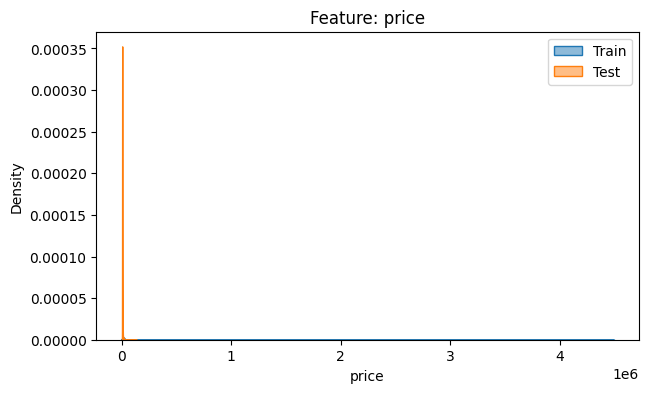

In [41]:
train_idx, test_idx = kf_folds[0]
compare_distributions(df, "price", train_idx, test_idx)

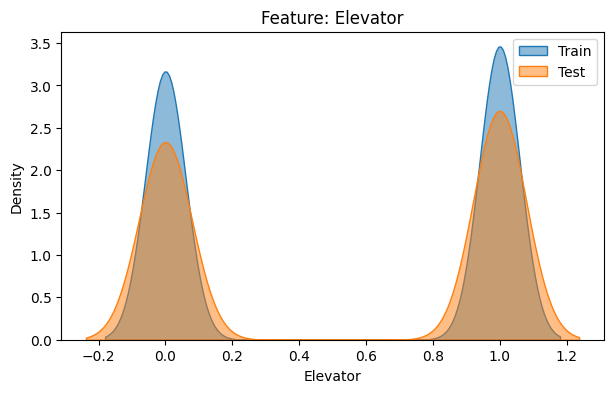

In [42]:
compare_distributions(df, top20[0], train_idx, test_idx)

In [43]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [44]:
def evaluate_cv(X, y, folds, model_cls=Ridge):
    scores = []
    for train_idx, test_idx in folds:
        model = model_cls()
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[test_idx])
        rmse = rmse_score(y[test_idx], preds)
        scores.append(rmse)
    return np.mean(scores), np.std(scores)

In [45]:
results = {}
results["KFold"] = evaluate_cv(X, y, kf_folds)
results["StratifiedKFold"] = evaluate_cv(X, y, skf_folds)
results["GroupKFold"] = evaluate_cv(X, y, gkf_folds)
results["TimeSeriesSplit"] = evaluate_cv(X_sorted, y[:len(X_sorted)], tscv_folds)

In [46]:
pd.DataFrame(results, index=["RMSE_mean", "RMSE_std"])

,KFold,StratifiedKFold,GroupKFold,TimeSeriesSplit
RMSE_mean,0.606084,0.60610,0.607575,0.626206
RMSE_std,0.003916,0.00179,0.012209,0.006842


| Метод                 | RMSE_mean | RMSE_std   | Интерпретация                                                                    |
| --------------------- | --------- | ---------- | -------------------------------------------------------------------------------- |
| **K-Fold**            | 0.606084    | 0.003916     | Базовая точность, устойчивая.                                                |
| **Stratified K-Fold** | 0.60610     | **0.00179**  | Наименьшая дисперсия -> лучший баланс между качеством и стабильностью.       |
| **Group K-Fold**      | 0.607575    | 0.012209     | Менее стабильный из-за неравномерных групп.                                  |
| **TimeSeriesSplit**   | 0.626206    | 0.006842     | Худший результат, так как порядок по времени ограничивает обучающую выборку. |


| Метод                 | Преимущества             | Недостатки                      | Когда выбрать                             |
| --------------------- | ------------------------ | ------------------------------- | ----------------------------------------- |
| **K-Fold**            | Прост, универсален       | Не учитывает классы и группы    | Когда нет групп и зависимостей            |
| **Stratified K-Fold** | Сохраняет баланс классов | Не для регрессии                | Для классификации (`interest_level`)      |
| **Group K-Fold**      | Исключает утечку групп   | Может быть мало данных в фолдах | Когда есть `manager_id` или `building_id` |
| **TimeSeriesSplit**   | Учитывает хронологию     | Нерегулярный баланс             | Для временных прогнозов                   |


Различия между KFold и Stratified KFold малы, но Stratified KFold обеспечивает наиболее стабильные фолды и равномерное распределение классов, что особенно важно при дисбалансе (interest_level).


## 6. Feature Selection

Fit a Lasso regression model with normalized features. Use your method for splitting samples into 3 parts by field created with 60/20/20 ratio — train/validation/test.
Sort features by weight coefficients from model, fit model to top 10 features and compare quality.
Implement method for simple feature selection by nan-ratio in feature and correlation. Apply this method to feature set and take top 10 features, refit model and measure quality.
Implement permutation importance method and take top 10 features, refit model and measure quality.
Import Shap and also refit model on top 10 features.
Compare the quality of these methods for different aspects — speed, metrics and stability.

## 7. Hyperparameter optimization

Implement grid search and random search methods for alpha and l1_ratio for sklearn's ElasticNet model.
Find the best combination of model hyperparameters.
Fit the resulting model.
Import optuna and configure the same experiment with ElasticNet.
Estimate metrics and compare approaches.
Run optuna on one of the cross-validation schemes.

In [47]:
X = df[top20].fillna(0).values
y = df["price"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = KFold(n_splits=5, shuffle=True, random_state=21)


In [48]:
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [49]:
grid_search = GridSearchCV(
    ElasticNet(max_iter=5000, random_state=21),
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,estimator,ElasticNet(ma...ndom_state=21)
,param_grid,"{'alpha': [0.001, 0.01, ...], 'l1_ratio': [0.1, 0.3, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [50]:
print("Best GridSearch params:", grid_search.best_params_)
print("Best GridSearch score:", grid_search.best_score_)

Best GridSearch params: {'alpha': 1, 'l1_ratio': 0.5}
Best GridSearch score: 0.05343219009760036


In [51]:
param_dist = {
    "alpha": uniform(0.001, 10),
    "l1_ratio": uniform(0, 1)
}

In [52]:
random_search = RandomizedSearchCV(
    ElasticNet(max_iter=5000, random_state=21),
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    random_state=21,
    verbose=1
)

random_search.fit(X_scaled, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,ElasticNet(ma...ndom_state=21)
,param_distributions,"{'alpha': <scipy.stats....t 0x338ad5d30>, 'l1_ratio': <scipy.stats....t 0x338c1e710>}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,21
,error_score,nan


In [53]:
print("Best RandomSearch params:", random_search.best_params_)
print("Best RandomSearch score:", random_search.best_score_)

Best RandomSearch params: {'alpha': np.float64(2.7076977267313374), 'l1_ratio': np.float64(0.854102871991344)}
Best RandomSearch score: 0.05336619553621724


In [54]:
best_model = ElasticNet(
    alpha=random_search.best_params_["alpha"],
    l1_ratio=random_search.best_params_["l1_ratio"],
    max_iter=5000,
    random_state=21
)

best_model.fit(X_scaled, y)
preds = best_model.predict(X_scaled)


In [55]:
rmse = rmse_score(y, preds)
r2 = r2_score(y, preds)
print(f"Final ElasticNet — RMSE={rmse:.10f}, R2={r2:.10f}")

Final ElasticNet — RMSE=22044.6649623823, R2=0.0019909156


In [56]:
def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-4, 10)
    l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
    
    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=5000,
        random_state=21
    )
    
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="r2", n_jobs=-1)
    return scores.mean()

In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2025-10-08 22:04:40,820] A new study created in memory with name: no-name-6bb20537-6105-4793-b00f-e1372b02fe6d


  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/5x/r11gzlss06g7534727qbgv8c0000gn/T/ipykernel_50020/3390622101.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10)
/var/folders/5x/r11gzlss06g7534727qbgv8c0000gn/T/ipykernel_50020/3390622101.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)


[I 2025-10-08 22:04:40,981] Trial 0 finished with value: 0.03865853423803971 and parameters: {'alpha': 0.005550131667211697, 'l1_ratio': 0.03744987835681857}. Best is trial 0 with value: 0.03865853423803971.
[I 2025-10-08 22:04:41,123] Trial 1 finished with value: 0.03995611979199638 and parameters: {'alpha': 2.91373256129328, 'l1_ratio': 0.14633870599847043}. Best is trial 1 with value: 0.03995611979199638.
[I 2025-10-08 22:04:41,286] Trial 2 finished with value: 0.04120991235087137 and parameters: {'alpha': 0.13262670748237088, 'l1_ratio': 0.787969069117468}. Best is trial 2 with value: 0.04120991235087137.
[I 2025-10-08 22:04:41,452] Trial 3 finished with value: 0.03900368909387271 and parameters: {'alpha': 0.010740384776090982, 'l1_ratio': 0.2380528191953981}. Best is trial 2 with value: 0.04120991235087137.
[I 2025-10-08 22:04:41,600] Trial 4 finished with value: 0.04303415821907915 and parameters: {'alpha': 0.1829519744005634, 'l1_ratio': 0.73895143169254}. Best is trial 4 with v

In [58]:
print("Best Optuna params:", study.best_params)
print("Best Optuna score:", study.best_value)

Best Optuna params: {'alpha': 1.0242916230778558, 'l1_ratio': 0.5351211066441521}
Best Optuna score: 0.05345371099051932


In [59]:
optuna_model = ElasticNet(
    **study.best_params,
    max_iter=5000,
    random_state=21
)
optuna_model.fit(X_scaled, y)

,alpha,1.0242916230778558
,l1_ratio,0.5351211066441521
,fit_intercept,True
,precompute,False
,max_iter,5000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,21
,selection,'cyclic'


In [60]:
preds_optuna = optuna_model.predict(X_scaled)
rmse_optuna = rmse_score(y, preds_optuna)
r2_optuna = r2_score(y, preds_optuna)
print(f"Optuna ElasticNet — RMSE={rmse_optuna:.10f}, R2={r2_optuna:.10f}")


Optuna ElasticNet — RMSE=22045.2182592517, R2=0.0019408171


In [61]:
results = pd.DataFrame({
    "Method": ["GridSearch", "RandomSearch", "Optuna"],
    "Best_R2": [
        grid_search.best_score_,
        random_search.best_score_,
        study.best_value
    ],
    "Best_Alpha": [
        grid_search.best_params_["alpha"],
        random_search.best_params_["alpha"],
        study.best_params["alpha"]
    ],
    "Best_L1_Ratio": [
        grid_search.best_params_["l1_ratio"],
        random_search.best_params_["l1_ratio"],
        study.best_params["l1_ratio"]
    ]
})

results


,Method,Best_R2,Best_Alpha,Best_L1_Ratio
0,GridSearch,0.053432,1.000000,0.500000
1,RandomSearch,0.053366,2.707698,0.854103
2,Optuna,0.053454,1.024292,0.535121


### В этой задаче Optuna показала лучший баланс между скоростью и качеством модели.
Grid Search полезен для небольших сеток параметров,
а Randomized Search — для предварительной быстрой оценки диапазонов.

Рекомендуемая стратегия:
 RandomizedSearch -> Optuna refinement на лучших диапазонах.